In [ ]:
# 버전
# python version : 3.7.13
# matplotlib version : 3.5.2
# openCV version : 4.6.0
# pytesseract version : 0.3.9
# googletrans : '3.1.0-alpha'
# PIL.Image : 9.2.0


# 버전 확인 코드
# openCV: cv2.__version__
# pytesseract :
# import pkg_resources
# pkg_resources.working_set.by_key['pytesseract'].version
# tf.__version__
# PIL.Image.__version__


In [7]:
# 필요한 패키지 임포트
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 이미지에서 텍스트 추출
import pytesseract
import os
import googletrans
from PIL import Image, ImageFont, ImageDraw

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' #테서랙트 설치된 경로


In [16]:
# 전처리 함수
def preprocessing(org_image):

    # 그레이 스케일 이미지
    gray_img = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

    # grayscale -> binary
    binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    return binary_img

In [17]:
# 번역 함수
def translate_result(string, lang='ko'):  # 기본적으로 한글로 번역

    translator = googletrans.Translator()

    result = translator.translate(string, dest=lang) # result는 번역 객체
    return result.text # 번역된 결과 text만 반환


In [18]:
# 이미지에 한글 출력하는 함수
# img는 cv2로 읽은 파일, string은 번역한 한글, x, y는 좌하단 좌표, fontsize는 폰트 크기, fontcolor는 폰트 컬러

def textImage(img, string, x, y, fontsize, fontcolor=(0,0,0)):
    
    pil_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # CV2를 RGB파일로
    pil_image = Image.fromarray(pil_image) # PIL이미지로 변환

    # 그리기 준비, 폰트 설정
    fontpath = './font/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
    font = ImageFont.truetype(fontpath, fontsize) # 폰트 종류, 크기 지정. 폰트 객체 생성
    draw = ImageDraw.Draw(pil_image) # 그리기 객체 생성

    draw.text((x, y), str(string), fontcolor, font=font) # 텍스트 그리기

    return pil_image

Text(0.5, 1.0, 'input text')

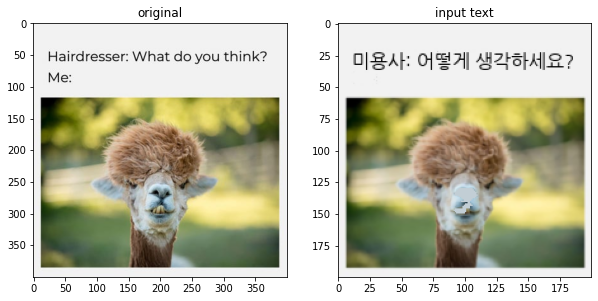

In [25]:
# 이미지를 불러오고 텍스트를 찾아서 지우고 번역한 텍스트를 삽입

large = cv2.imread('./imgs/meme.jpeg') #이미지 불러오기
rgb = cv2.pyrDown(large) #크기 줄이기
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY) # BGR->GRAY
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) # 요소 탐색 모양  타원으로 결정
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel) # 이미지 침식
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # 임계값 찾음
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1)) #  사각형 커널 
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel) # 구멍 메우는 용도
contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# cntours: 검출된 외곽선 좌표. numpy.ndarray로 구성된 리스트. len(contours)=전체 외곽선 개수(N). contours[i].shape=(K, 1, 2). contours[i].dtype=numpy.int32.
# hierarchy: 외곽선 계층 정보. numpy.ndarray. shape=(1, N, 4). dtype=numpy.int32. hierarchy[0, i, 0] ~ hierarchy[0, i, 3]이 순서대로 next, prev, child, parent 외곽선 인덱스를 가리킴. 해당 외곽선이 없으면 -1.
mask = np.zeros(bw.shape, dtype=np.uint8) # 기본 마스크는 bgr, 전부 0이다.

# 찾은 글자 박스 하나씩 돌면서
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx]) # 박스 하나의 x, y, w, h
    mask[y:y+h, x:x+w] = 0 # 원본 이미지에서 텍스트를 발견한 부분을 마스크에서 0으로 만듦
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
                # mask에 contours를 그린다
                # idx = 포인트 어레이 인덱스
                # 컨투어 색상은 (255,255,255)
                # 컨투어 라인 두께 : -1

    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h) 
    # mask 내 0이 아닌 부분 검출한 후 비율을 계산해서 0.45보다 크면


    if r > 0.45 and w > 8 and h > 8: # 0.45보다 크고 박스 크기가 일정 이상이라면.

        # 글자 있는 부분만 잘라서 전처리
        img = preprocessing(rgb[y:y+h, x:x+w])
        
        # 글자 검출
        txt = pytesseract.image_to_string(img,
                        lang='ENG',config='--psm 4 -c preserve_interword_spaces=1')
        
        # 추출한 텍스트 번역기에 넣고 결과 받음
        result = ''
        if txt!='':
            result = translate_result(string=txt)        


        # 글자 있던 부분의 좌측 하단 색상을 받아와 글자 검출된 박스 전체를 칠함.
        b,g,r = rgb[y,x] # 상자 좌측하단 좌표의 색을 받아옴.
        cv2.drawContours(rgb, contours, idx, (float(b),float(g),float(r)), -1)
       
        # 번역 결과 result를 이미지에 그리기
        img = textImage(rgb, string=result, x=x, y=y, fontsize=15, fontcolor=(0,0,0))
        
# 출력 이미지 크기 설정
plt.figure(figsize=(10,12))

# 원본 이미지
ori_img = cv2.imread('./imgs/meme.jpeg')
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(ori_img)
plt.title('original')

# 번역된 글자가 삽입된 이미지 출력
plt.subplot(1,2,2)
plt.imshow(img)
plt.title('input text')
